# TD SQL Avancé avec Postgres et SQLAlchemy


Ce TD vous permettra de pratiquer des concepts SQL avancés à travers une série d'exercices progressifs. Vous commencerez par des requêtes SQL pures avant de découvrir l'utilisation de l'ORM SQLAlchemy.

### Objectifs pédagogiques
- Maîtriser les expressions conditionnelles CASE WHEN
- Comprendre et utiliser les Window Functions
- Utiliser les Common Table Expressions (CTEs)
- Découvrir l'ORM SQLAlchemy et ses fonctionnalités

### Prérequis
- Python 3.8+
- Connaissances de base en SQL (SELECT, JOIN, GROUP BY)
- Notions de Python

### Installation et configuration initiale
Commencez par installer les dépendances nécessaires :

In [1]:
!pip install psycopg2-binary sqlalchemy pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.3 MB/s eta 0:00:0000:0100:01


### Configuration de l'environnement de travail
Exécutez cette cellule pour configurer votre environnement :

In [3]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine, text
import warnings
warnings.filterwarnings('ignore')

DB_CONFIG = {
    'dbname': 'workshop',
    'user': 'root',
    'password': 'example',
    'host': 'postgres',
    'port': '5432'
}
db_name="workshop", user="root", 

def test_postgres_connection():
    try:
        conn = psycopg2.connect(
            **DB_CONFIG
        )
        conn.close()
        return True
    except:
        return False


In [4]:
print(test_postgres_connection())
# Doit afficher True

True


In [5]:
help(psycopg2.connect)

Help on function connect in module psycopg2:

connect(dsn=None, connection_factory=None, cursor_factory=None, **kwargs)
    Create a new database connection.
    
    The connection parameters can be specified as a string:
    
        conn = psycopg2.connect("dbname=test user=postgres password=secret")
    
    or using a set of keyword arguments:
    
        conn = psycopg2.connect(database="test", user="postgres", password="secret")
    
    Or as a mix of both. The basic connection parameters are:
    
    - *dbname*: the database name
    - *database*: the database name (only as keyword argument)
    - *user*: user name used to authenticate
    - *password*: password used to authenticate
    - *host*: database host address (defaults to UNIX socket if not provided)
    - *port*: connection port number (defaults to 5432 if not provided)
    
    Using the *connection_factory* parameter a different class or connections
    factory can be specified. It should be a callable object tak

In [8]:
def execute_sql(query, return_data=True):
    """
    Fonction utilitaire pour exécuter vos requêtes SQL
    
    Paramètres :
    query : str - Votre requête SQL
    return_data : bool - True pour SELECT, False pour INSERT/UPDATE/DELETE
    
    Retourne :
    DataFrame avec vos résultats si return_data=True
    """
    try:
        with psycopg2.connect(**DB_CONFIG) as conn:
            if return_data:
                return pd.read_sql_query(query, conn)
            else:
                with conn.cursor() as cur:
                    cur.execute(query)
                    conn.commit()
        print("✅ Requête exécutée avec succès!")
    except Exception as e:
        print(f"❌ Erreur: {str(e)}")

### Création des données de test
Exécutez cette cellule pour créer et peupler les tables de test :


In [6]:
SETUP_QUERIES = """
CREATE TABLE IF NOT EXISTS employes (
    id SERIAL PRIMARY KEY,
    nom VARCHAR(100),
    departement VARCHAR(50),
    salaire DECIMAL(10,2),
    date_embauche DATE,
    manager_id INTEGER REFERENCES employes(id)
);

CREATE TABLE IF NOT EXISTS ventes (
    id SERIAL PRIMARY KEY,
    employe_id INTEGER REFERENCES employes(id),
    produit VARCHAR(100),
    montant DECIMAL(10,2),
    date_vente DATE
);

-- Données de test
INSERT INTO employes (nom, departement, salaire, date_embauche, manager_id) VALUES
    ('Alice Martin', 'Ventes', 45000, '2020-01-15', NULL),
    ('Bob Dupont', 'Ventes', 42000, '2020-03-01', 1),
    ('Claire Thomas', 'Marketing', 48000, '2019-11-01', NULL),
    ('David Bernard', 'Marketing', 51000, '2019-06-15', 3),
    ('Emma Petit', 'IT', 55000, '2018-12-01', NULL),
    ('François Dubois', 'IT', 47000, '2021-01-15', 5),
    ('Gaelle Leroy', 'Ventes', 43000, '2021-06-01', 1)
ON CONFLICT DO NOTHING;

INSERT INTO ventes (employe_id, produit, montant, date_vente) VALUES
    (1, 'Laptop Pro', 1500, '2023-01-15'),
    (1, 'Laptop Pro', 2000, '2023-01-16'),
    (2, 'Desktop Ultra', 1800, '2023-01-15'),
    (2, 'Laptop Basic', 800, '2023-01-17'),
    (7, 'Desktop Ultra', 1800, '2023-01-15'),
    (7, 'Laptop Pro', 2000, '2023-01-16'),
    (3, 'Laptop Gaming', 2200, '2023-01-16')
ON CONFLICT DO NOTHING;

CREATE TABLE IF NOT EXISTS categories_produits (
    id SERIAL PRIMARY KEY,
    nom VARCHAR(100),
    categorie_parent_id INTEGER REFERENCES categories_produits(id)
);

CREATE TABLE IF NOT EXISTS historique_prix (
    id SERIAL PRIMARY KEY,
    produit VARCHAR(100),
    prix DECIMAL(10,2),
    date_changement DATE,
    raison_changement VARCHAR(200)
);

INSERT INTO categories_produits (nom, categorie_parent_id) VALUES
    ('Informatique', NULL),
    ('Ordinateurs', 1),
    ('Laptops', 2),
    ('Desktops', 2),
    ('Laptop Gaming', 3),
    ('Laptop Pro', 3),
    ('Desktop Ultra', 4);

INSERT INTO historique_prix (produit, prix, date_changement, raison_changement) VALUES
    ('Laptop Pro', 2000, '2023-01-01', 'Prix initial'),
    ('Laptop Pro', 1800, '2023-01-10', 'Promotion hiver'),
    ('Laptop Pro', 1900, '2023-01-15', 'Fin promotion'),
    ('Laptop Pro', 1700, '2023-01-20', 'Nouveau modèle sortie');
"""

In [9]:
# Exécution du setup
execute_sql(SETUP_QUERIES, return_data=False)

✅ Requête exécutée avec succès!


In [10]:
execute_sql("SELECT * FROM historique_prix", return_data=True)

,id,produit,prix,date_changement,raison_changement
0,1,Laptop Pro,2000.0,2023-01-01,Prix initial
1,2,Laptop Pro,1800.0,2023-01-10,Promotion hiver
2,3,Laptop Pro,1900.0,2023-01-15,Fin promotion
3,4,Laptop Pro,1700.0,2023-01-20,Nouveau modèle sortie


## Exercice 1 : CASE WHEN (20 minutes)

### Contexte
Le service RH souhaite mettre en place un nouveau système de classification des employés et de calcul des primes basé sur plusieurs critères.

### Objectif
Créer une requête qui produit un rapport complet sur les employés avec :
- Une classification selon le salaire ET l'ancienneté
- Un calcul de prime personnalisé

### Consignes détaillées
1. Classifiez les employés selon :
   - Le salaire : "Junior" (<45000), "Confirmé" (45000-50000), "Senior" (>50000)
   - L'ancienneté : "Nouveau" (2021 ou après), "Expérimenté" (2019-2020), "Vétéran" (avant 2019)

2. Calculez une prime selon la formule :
   - Base : 5% du salaire pour tout le monde
   - +2% si "Expérimenté", +5% si "Vétéran"
   - +3% si a réalisé au moins une vente

Résultat attendu :
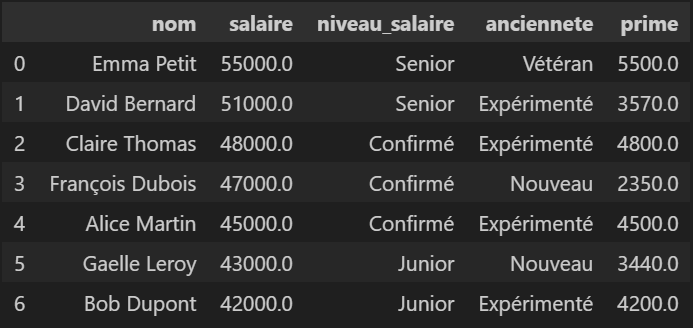

In [11]:
# Votre requête ici
query1 = """
SELECT 
    nom,
    salaire,
    -- Classification salaire
    CASE 
        WHEN salaire < 45000 THEN 'Junior'
        WHEN salaire <= 50000 THEN 'Confirmé'
        ELSE 'Senior'
    END as niveau_salaire,
    
    -- Classification ancienneté
    CASE 
        WHEN date_embauche >= '2021-01-01' THEN 'Nouveau'
        WHEN date_embauche >= '2019-01-01' THEN 'Expérimenté'
        ELSE 'Vétéran'
    END as anciennete,
    
    -- Calcul de la prime
    ROUND(salaire * (
        0.05  -- Base 5%
        + CASE  -- Bonus ancienneté
            WHEN date_embauche < '2019-01-01' THEN 0.05
            WHEN date_embauche < '2021-01-01' THEN 0.02
            ELSE 0
          END
        + CASE  -- Bonus ventes
            WHEN EXISTS (SELECT 1 FROM ventes v WHERE v.employe_id = e.id) THEN 0.03
            ELSE 0
          END
    ), 2) as prime
FROM employes e
ORDER BY salaire DESC;
"""

result1 = execute_sql(query1)
display(result1)

,nom,salaire,niveau_salaire,anciennete,prime
0,Emma Petit,55000.0,Senior,Vétéran,5500.0
1,David Bernard,51000.0,Senior,Expérimenté,3570.0
2,Claire Thomas,48000.0,Confirmé,Expérimenté,4800.0
3,François Dubois,47000.0,Confirmé,Nouveau,2350.0
4,Alice Martin,45000.0,Confirmé,Expérimenté,4500.0
5,Gaelle Leroy,43000.0,Junior,Nouveau,3440.0
6,Bob Dupont,42000.0,Junior,Expérimenté,4200.0


## Exercice 2 : Common Table Expressions (20 minutes)

### Contexte
Vous travaillez sur l'analyse des ventes de l'entreprise et devez tracer l'historique des promotions sur les produits ainsi que l'évolution des prix.

### Objectif
Utiliser les CTEs pour :
Analyser les performances de vente par catégorie de produits (CTE simple)

### Consignes détaillées

Écrivez une requête qui utilise une CTE pour :
- Regrouper les ventes par catégorie de produits
- Calculer le total et la moyenne des ventes par catégorie
- Identifier la meilleure vente dans chaque catégorie

Résultat attendu :
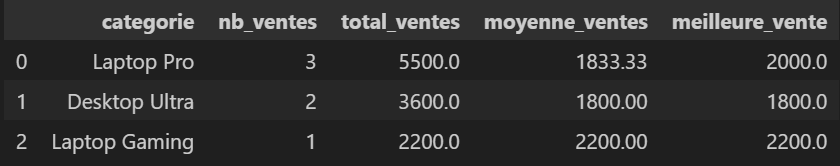


In [ ]:
query2 = """

"""

result2 = execute_sql(query2)
display(result2)

## Exercice 3 : Window Functions (25 minutes)

### Contexte
Le service commercial souhaite une analyse détaillée des performances de vente pour identifier les meilleurs vendeurs et suivre leur évolution.

### Objectif
Créer une analyse complète des ventes utilisant plusieurs fonctions de fenêtrage pour :
- Classer les vendeurs
- Calculer des cumuls
- Comparer avec les moyennes du département

### Consignes détaillées
Écrivez une requête qui affiche pour chaque vendeur :
1. Son classement global selon le montant total des ventes (RANK)
2. Son classement dans son département (RANK OVER PARTITION)
3. Le cumul de ses ventes jour par jour
4. L'écart (en %) entre son total de ventes et la moyenne de son département

Résultat attendu :

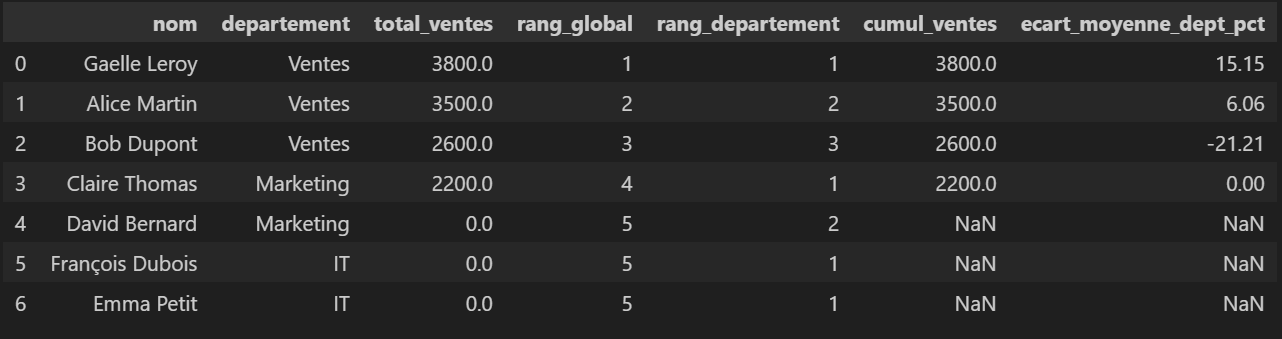

In [ ]:
query3 = """

"""

result3 = execute_sql(query3)
display(result3)

## Exercice 4 : CTE Récursive (20 minutes)

### Contexte
Vous travaillez sur l'analyse des ventes de l'entreprise et devez tracer l'historique des promotions sur les produits ainsi que l'évolution des prix.

### Objectif
Utiliser les CTEs Récursives pour :

Tracer l'évolution du prix d'un produit dans le temps (CTE récursive).

### Consignes détaillées

Écrivez une requête qui utilise une CTE récursive pour :
- Tracer l'évolution du prix d'un produit
- Calculer la variation par rapport au prix précédent
- Afficher une chaîne montrant la séquence des changements

Résultat attendu :
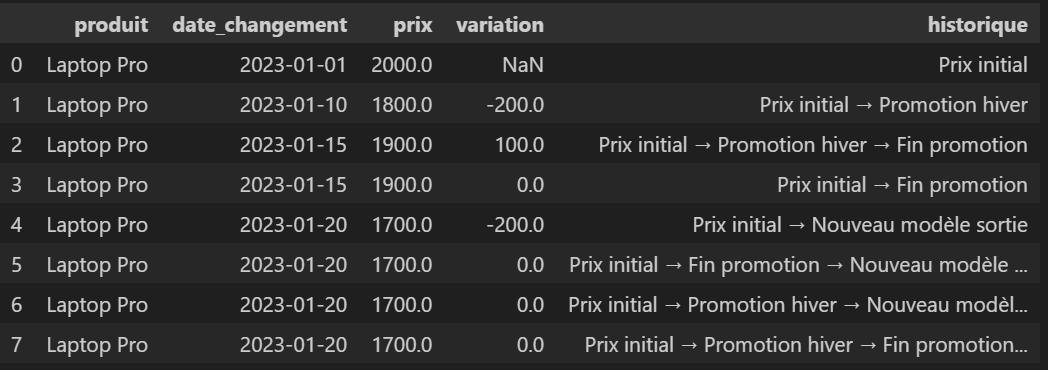

In [ ]:
query4 = """

"""

result4 = execute_sql(query4)
display(result4)

## Exercice 5 : SQLAlchemy et Gestion de Données (25 minutes)

### Contexte
Vous développez une API de gestion des produits et des commandes pour une boutique en ligne. Vous devez implémenter les opérations CRUD (Create, Read, Update, Delete) et gérer les transactions de manière sécurisée.


### Configuration initiale

In [ ]:
from sqlalchemy import create_engine, Column, Integer, String, Numeric, Date, ForeignKey, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
from datetime import datetime
from typing import List
import json

# Configuration
DATABASE_URL = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"
engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
Base = declarative_base()

# Modèles
class Produit(Base):
    __tablename__ = 'produits'
    
    id = Column(Integer, primary_key=True)
    nom = Column(String(100), nullable=False)
    description = Column(String)
    prix = Column(Numeric(10, 2), nullable=False)
    stock = Column(Integer, default=0)
    
    commandes = relationship("LigneCommande", back_populates="produit")

class Client(Base):
    __tablename__ = 'clients'
    
    id = Column(Integer, primary_key=True)
    nom = Column(String(100), nullable=False)
    email = Column(String(100), unique=True, nullable=False)
    
    commandes = relationship("Commande", back_populates="client")

class Commande(Base):
    __tablename__ = 'commandes'
    
    id = Column(Integer, primary_key=True)
    client_id = Column(Integer, ForeignKey('clients.id'), nullable=False)
    date_commande = Column(Date, default=func.current_date())
    statut = Column(String(20), default='en_attente')
    
    client = relationship("Client", back_populates="commandes")
    lignes = relationship("LigneCommande", back_populates="commande")

class LigneCommande(Base):
    __tablename__ = 'lignes_commande'
    
    id = Column(Integer, primary_key=True)
    commande_id = Column(Integer, ForeignKey('commandes.id'), nullable=False)
    produit_id = Column(Integer, ForeignKey('produits.id'), nullable=False)
    quantite = Column(Integer, nullable=False)
    prix_unitaire = Column(Numeric(10, 2), nullable=False)
    
    commande = relationship("Commande", back_populates="lignes")
    produit = relationship("Produit", back_populates="commandes")

# Création des tables
Base.metadata.create_all(engine)

### Consignes détaillées

5.1) Opérations CRUD de base
Créez des fonctions pour gérer les produits :
- Ajouter un nouveau produit
- Mettre à jour le stock
- Récupérer les produits par critères
- Supprimer un produit (avec vérification)

In [ ]:
# 5.1 CRUD Operations
def ajouter_produit(nom: str, description: str, prix: float, stock: int = 0) -> Produit:
    session = Session()

    produit = Produit(
        nom=nom,
        description=description,
        prix=prix,
        stock=stock
    )
    session.add(produit)
    session.commit()
    session.refresh(produit)
    return produit


def rechercher_produits(min_prix: float = None, max_prix: float = None, en_stock: bool = None) -> List[Produit]:
    session = Session()

    query = session.query(Produit)
    if min_prix:
        query = query.filter(Produit.prix >= min_prix)
    if max_prix:
        query = query.filter(Produit.prix <= max_prix)
    if en_stock:
        query = query.filter(Produit.stock > 0)
    return query.all()


def mettre_a_jour_stock(produit_id: int, quantite: int) -> bool:
    session = Session()

    produit = session.query(Produit).get(produit_id)
    if not produit:
        return False
    produit.stock += quantite
    session.commit()
    return True

        
# 5.2 Transaction
def traiter_commande(client_id: int, items: List[dict]) -> Commande:
    session = Session()

    # Création de la commande
    commande = Commande(client_id=client_id)
    session.add(commande)
    
    # Traitement des items
    for item in items:
        produit = session.query(Produit).get(item['produit_id'])
        if produit.stock < item['quantite']:
            raise ValueError(f"Stock insuffisant pour {produit.nom}")
        
        # Création ligne commande
        ligne = LigneCommande(
            commande=commande,
            produit_id=produit.id,
            quantite=item['quantite'],
            prix_unitaire=produit.prix
        )
        session.add(ligne)
        
        # Mise à jour stock
        produit.stock -= item['quantite']
    
    session.commit()
    return commande

def trouver_un_produit_par(id: str, nom: str):
    """
    TO COMPLETE
    """

In [ ]:
# Cellule 1 : Test d'insertion simple
produit1 = ajouter_produit(
    nom="MacBook Pro", 
    description="Ordinateur portable Apple M2",
    prix=1299.99,
    stock=5
)
print(f"Produit ajouté: {produit1.nom} (ID: {produit1.id})")

In [ ]:
produits = [
    {
        "nom": "Laptop Pro",
        "description": "Ordinateur portable haut de gamme",
        "prix": 1299.99,
        "stock": 10
    },
    {
        "nom": "Souris Gaming",
        "description": "Souris RGB 12000 DPI",
        "prix": 79.99,
        "stock": 20
    }
]

for p in produits:
    nouveau_produit = ajouter_produit(**p)
    print(f"Produit ajouté: {nouveau_produit.nom} {nouveau_produit.id}")

In [ ]:
# Cellule 4 : Recherche des produits en stock
produits_disponibles = rechercher_produits(en_stock=True)
print("\nProduits en stock:")
for p in produits_disponibles:
    print(f"- {p.id} - {p.nom}: {p.stock} unités")

In [ ]:
# Cellule 5 : Test de mise à jour du stock
produit_id = 40  # Utilisez un ID existant
resultat = mettre_a_jour_stock(produit_id, -5)  # Retrait de 2 unités
if resultat:
    session = Session()
    produit = session.query(Produit).get(produit_id)
    print(f"Stock de {produit.nom} mis à jour: {produit.stock} unités")
else:
    print("Mise à jour échouée")

In [ ]:
# Cellule 6 : Test de recherche par nom
produits_apple = trouver_un_produit_par(nom="MacBook Pro")
print("\nRecherche par nom 'MacBook Pro':")

print(f"- {produits_apple.nom}: {produits_apple.description}")

In [ ]:
session = Session()
session.query(LigneCommande).delete()
session.query(Commande).delete()
session.query(Client).delete()
session.query(Produit).delete()
session.commit()


5.2) Opérations en Bulk et Transactions
Créez une fonction qui gère une commande complète avec gestion des transactions :
- Vérification du stock
- Création de la commande
- Mise à jour des stocks
- Rollback en cas d'erreur

In [ ]:
def traiter_commande(client_id: int, items: List[dict]) -> Commande:
    """
    Traite une nouvelle commande avec plusieurs produits
    
    Args:
        client_id: ID du client
        items: Liste de dictionnaires {produit_id: int, quantite: int}
    """
    session = Session()
    try:
        # Votre code ici - Pensez à :
        # 1. Vérifier que tous les produits sont disponibles
        # 2. Créer la commande
        # 3. Créer les lignes de commande
        # 4. Mettre à jour les stocks
        # 5. Commit si tout est OK
        
    except Exception as e:
        session.rollback()
        raise e
    finally:
        session.close()

5.3) Requêtes complexes pour API
Créez des fonctions qui seront utiles pour une API :
- Obtenir l'historique des commandes d'un client
- Calculer les statistiques de ventes
- Recherche avancée de produits

In [ ]:
def historique_client(client_id: int) -> List[dict]:
    """Retourne l'historique complet des commandes d'un client"""
    # Votre code ici
    

def statistiques_ventes(date_debut: Date = None, date_fin: Date = None) -> dict:
    """Calcule les statistiques de ventes sur une période"""
    # Votre code ici
    

# Test des fonctions
try:
    # Testez vos fonctions ici
    
except Exception as e:
    print(f"❌ Erreur: {str(e)}")

In [ ]:
# Test de la fonction avec une commande multi-produits
commande_test = [
    {"produit_id": 1, "quantite": 2},
    {"produit_id": 2, "quantite": 1}
]

try:
    # Testez votre fonction ici
    
except Exception as e:
    print(f"❌ Erreur: {str(e)}")

## Conclusion du TD

Vous avez pratiqué :
1. Les expressions conditionnelles complexes
2. Les fonctions de fenêtrage pour l'analyse
3. Les CTEs pour la récursivité et la lisibilité
4. L'utilisation de SQLAlchemy pour l'analyse de données

Points clés à retenir :
- L'importance de la structuration des requêtes
- La puissance des Window Functions pour l'analyse
- L'utilité des CTEs pour la clarté du code
- La flexibilité offerte par SQLAlchemy
